# Lesson 7 from fast.ai
https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/

### Basic Setup

In [1]:
from theano.sandbox import cuda

from imp import reload
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

import numpy as np
import h5py

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)
Using Theano backend.


In [2]:
get_ipython().magic('load_ext cellevents')

In [3]:
#path = "/home/jd/data/fish/sample/"
path = "/home/jd/data/fish/"
batch_size=64

time: 4.29 ms


## Start Pulling in data

Correct formatting dictates that we have a valid set

/home/jd/data/fish/sample/valid


/home/jd/data/fish/valid

In [4]:
# St up all the the files correctly look at the filemover for details
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 3617 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Found 3617 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.
time: 145 ms


In [5]:
# Not sure if I solved this but will include
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

time: 3.35 ms


## Basic VGG

In [6]:
from vgg16bn import Vgg16BN

time: 1.37 ms


In [7]:
# Be careful about pulling all of the good data down from vgg. 
#If interupted everything will fail
model = vgg_ft_bn(8)

time: 3.14 s


In [8]:
# Pulls in all of our image data
trn = get_data(path+'train')
val = get_data(path+'valid')
test = get_data(path+'test')

Found 3617 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.
time: 1min 30s


In [9]:
# Saves the arrary of weights
save_array(path+'results/trn.dat', trn)
save_array(path+'results/val.dat', val)
save_array(path+'results/test.dat', test)

time: 2.03 s


In [10]:
# Loads the array of weights
trn = load_array(path+'results/trn.dat')
val = load_array(path+'results/val.dat')
test = load_array(path+'results/test.dat')

time: 1.22 s


### Create Models

In [11]:
# Fires up the image generator
gen = image.ImageDataGenerator()

time: 775 µs


In [12]:
# Starts to run the model
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

time: 10.7 ms


In [13]:
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 3617 samples, validate on 400 samples
Epoch 1/3
3617/3617 [==============================] - 60s - loss: 2.8762 - acc: 0.4816 - val_loss: 3.6885 - val_acc: 0.4000
Epoch 2/3
3617/3617 [==============================] - 60s - loss: 1.5921 - acc: 0.6378 - val_loss: 1.6089 - val_acc: 0.6275
Epoch 3/3
3617/3617 [==============================] - 60s - loss: 1.2499 - acc: 0.7255 - val_loss: 0.7661 - val_acc: 0.8075


time: 3min 9s


In [14]:
model.save_weights(path+'results/ft1.h5')

time: 1.35 s


### Create the convolutional output


In [15]:
model.load_weights(path+'results/ft1.h5')

time: 217 ms


In [16]:
conv_layers,fc_layers = split_at(model, Convolution2D)

time: 665 µs


In [17]:
conv_model = Sequential(conv_layers)

time: 60.6 ms


In [18]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)

time: 58.9 s


In [19]:
conv_test_feat = conv_model.predict(test)

time: 14.2 s


In [20]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)

time: 1.22 s


In [21]:
save_array(path+'results/conv_test_feat.dat', conv_test_feat)

time: 375 ms


In [22]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

time: 703 ms


In [23]:
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

time: 245 ms


In [24]:
conv_val_feat.shape

(400, 512, 14, 14)

time: 3.56 ms


### Train model


In [25]:
# Creates model with batchnorm layers
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

time: 3.91 ms


In [26]:
# for dropout
p=0.6

time: 1.38 ms


In [27]:
# Creates a model with sequencial layers 
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

time: 265 ms


In [28]:
# quick model run
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 3617 samples, validate on 400 samples
Epoch 1/3
3617/3617 [==============================] - 1s - loss: 1.0738 - acc: 0.6989 - val_loss: 0.5294 - val_acc: 0.8750
Epoch 2/3
3617/3617 [==============================] - 1s - loss: 0.2856 - acc: 0.9160 - val_loss: 0.1432 - val_acc: 0.9600
Epoch 3/3
3617/3617 [==============================] - 1s - loss: 0.1688 - acc: 0.9552 - val_loss: 0.0931 - val_acc: 0.9750


time: 7.86 s


In [29]:
# Fine tune weights
bn_model.optimizer.lr = 1e-4

time: 644 µs


In [30]:
# batchnorm model fit
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 3617 samples, validate on 400 samples
Epoch 1/7
3617/3617 [==============================] - 1s - loss: 0.0994 - acc: 0.9690 - val_loss: 0.0698 - val_acc: 0.9800
Epoch 2/7
3617/3617 [==============================] - 1s - loss: 0.0695 - acc: 0.9834 - val_loss: 0.0811 - val_acc: 0.9850
Epoch 3/7
3617/3617 [==============================] - 1s - loss: 0.0651 - acc: 0.9842 - val_loss: 0.0648 - val_acc: 0.9850
Epoch 4/7
3617/3617 [==============================] - 1s - loss: 0.0531 - acc: 0.9881 - val_loss: 0.0959 - val_acc: 0.9775
Epoch 5/7
3617/3617 [==============================] - 1s - loss: 0.0355 - acc: 0.9903 - val_loss: 0.0570 - val_acc: 0.9875
Epoch 6/7
3617/3617 [==============================] - 1s - loss: 0.0322 - acc: 0.9934 - val_loss: 0.0713 - val_acc: 0.9850
Epoch 7/7
3617/3617 [==============================] - 1s - loss: 0.0313 - acc: 0.9925 - val_loss: 0.0533 - val_acc: 0.9900


time: 9.28 s


In [31]:
# Makes the weights file
bn_model.save_weights(path+'models/conv_512_6.h5')

time: 111 ms


In [32]:
# Strange one
bn_model.evaluate(conv_val_feat, val_labels)

224/400 [===============>..............] - ETA: 0s

[0.053309812369989232, 0.98999999999999999]

time: 108 ms


In [33]:
#Saves teh weights
bn_model.load_weights(path+'models/conv_512_6.h5')

time: 27.2 ms


## Multi-input

In [34]:
#Makes a different set of data for all filenames in the train path
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
# left half of list image size
id2size = list(set(sizes))
# Right half is the id of vessel
size2id = {o:i for i,o in enumerate(id2size)}

time: 253 ms


In [35]:
#creates a collection
import collections
collections.Counter(sizes)

Counter({(1192, 670): 195,
         (1244, 700): 26,
         (1276, 718): 215,
         (1280, 720): 2070,
         (1280, 750): 578,
         (1280, 924): 59,
         (1280, 974): 373,
         (1334, 750): 30,
         (1518, 854): 37,
         (1732, 974): 34})

time: 5.92 ms


In [36]:
#What is this?
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

time: 1.68 ms


In [37]:
#
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

time: 29.8 ms


In [38]:
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

time: 1.94 ms


In [39]:
# dropout
p=0.6

time: 704 µs


In [40]:
inp = Input(conv_layers[-1].output_shape[1:])
sz_inp = Input((len(id2size),))
bn_inp = BatchNormalization()(sz_inp)

x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = merge([x,bn_inp], 'concat')
x = Dense(8, activation='softmax')(x)

time: 283 ms


In [41]:
model = Model([inp, sz_inp], x)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

time: 6.43 ms


In [42]:
model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=([conv_val_feat, val_sizes], val_labels))

Train on 3617 samples, validate on 400 samples
Epoch 1/3
3617/3617 [==============================] - 1s - loss: 1.1501 - acc: 0.6638 - val_loss: 0.3491 - val_acc: 0.9125
Epoch 2/3
3617/3617 [==============================] - 1s - loss: 0.2950 - acc: 0.9171 - val_loss: 0.1589 - val_acc: 0.9600
Epoch 3/3
3617/3617 [==============================] - 1s - loss: 0.1694 - acc: 0.9538 - val_loss: 0.1054 - val_acc: 0.9650


time: 9.01 s


In [43]:
bn_model.optimizer.lr = 1e-4

time: 582 µs


In [44]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=8, 
             validation_data=(conv_val_feat, val_labels))

Train on 3617 samples, validate on 400 samples
Epoch 1/8
3617/3617 [==============================] - 1s - loss: 0.0295 - acc: 0.9936 - val_loss: 0.0713 - val_acc: 0.9900
Epoch 2/8
3617/3617 [==============================] - 1s - loss: 0.0280 - acc: 0.9914 - val_loss: 0.0796 - val_acc: 0.9875
Epoch 3/8
3617/3617 [==============================] - 1s - loss: 0.0256 - acc: 0.9912 - val_loss: 0.0885 - val_acc: 0.9850
Epoch 4/8
3617/3617 [==============================] - 1s - loss: 0.0242 - acc: 0.9914 - val_loss: 0.0876 - val_acc: 0.9850
Epoch 5/8
3617/3617 [==============================] - 1s - loss: 0.0183 - acc: 0.9942 - val_loss: 0.0683 - val_acc: 0.9900
Epoch 6/8
3617/3617 [==============================] - 1s - loss: 0.0275 - acc: 0.9925 - val_loss: 0.0901 - val_acc: 0.9825
Epoch 7/8
3617/3617 [==============================] - 1s - loss: 0.0205 - acc: 0.9945 - val_loss: 0.0727 - val_acc: 0.9875
Epoch 8/8
3617/3617 [==============================] - 1s - loss: 0.0188 - acc: 0.993

time: 10.7 s


## Bounding boxes & multi output

In [45]:
import ujson as json

time: 3.62 ms


In [46]:
# Different classes of fish
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

time: 726 µs


In [47]:
# adds annotations to the files
# The files need to be saved from https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/discussion/25902
# Dont forget the "other" which is hidden part way down
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

time: 22.5 ms


In [48]:
# Test
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

time: 1.79 ms


In [49]:
#creates two lists wiht the file names and values
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

time: 2.86 ms


In [50]:
# Creates an empty box for testing
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

time: 1.4 ms


In [51]:
# If no boxes make an empty one
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

time: 4.75 ms


In [52]:
# resize everything and adjust the boxes to our new images
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

time: 6.68 ms


In [53]:
# makes the trn set and validation set
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

time: 20.5 ms


In [54]:
# creates the red rectangle
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

# pulls image and throws rectangle over it
def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

time: 4.51 ms


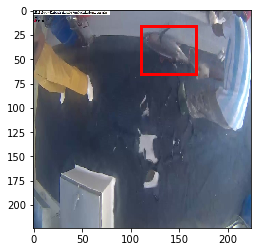

time: 144 ms


In [55]:
# Tests to show that fish is properly there
show_bb(5)

### Create & train model
Note from Jeremy: Since we're not allowed (by the kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image. To do so, we create a model with multiple outputs: it will predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [56]:
# Set Dropout
p=0.6

time: 643 µs


In [57]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

time: 275 ms


In [58]:
# creating a model with two very different outputs
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

time: 12.5 ms


In [59]:
# Run the model
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3617 samples, validate on 400 samples
Epoch 1/3
3617/3617 [==============================] - 1s - loss: 6.0735 - bb_loss: 5010.1992 - class_loss: 1.0633 - bb_acc: 0.4556 - class_acc: 0.6904 - val_loss: 5.2893 - val_bb_loss: 4601.6795 - val_class_loss: 0.6876 - val_bb_acc: 0.5725 - val_class_acc: 0.8775
Epoch 2/3
3617/3617 [==============================] - 1s - loss: 4.9424 - bb_loss: 4655.4695 - class_loss: 0.2869 - bb_acc: 0.5400 - class_acc: 0.9140 - val_loss: 4.3632 - val_bb_loss: 4191.4909 - val_class_loss: 0.1717 - val_bb_acc: 0.5325 - val_class_acc: 0.9525
Epoch 3/3
3617/3617 [==============================] - 1s - loss: 4.2241 - bb_loss: 4077.4497 - class_loss: 0.1466 - bb_acc: 0.5510 - class_acc: 0.9577 - val_loss: 3.6411 - val_bb_loss: 3535.6651 - val_class_loss: 0.1054 - val_bb_acc: 0.6300 - val_class_acc: 0.9725


time: 8.77 s


In [60]:
# Change up the weights
model.optimizer.lr = 1e-5

time: 726 µs


In [61]:
# Run some more
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3617 samples, validate on 400 samples
Epoch 1/10
3617/3617 [==============================] - 1s - loss: 3.4607 - bb_loss: 3349.6477 - class_loss: 0.1111 - bb_acc: 0.5975 - class_acc: 0.9665 - val_loss: 2.9718 - val_bb_loss: 2918.5671 - val_class_loss: 0.0532 - val_bb_acc: 0.6475 - val_class_acc: 0.9875
Epoch 2/10
3617/3617 [==============================] - 1s - loss: 2.5684 - bb_loss: 2502.3693 - class_loss: 0.0661 - bb_acc: 0.6420 - class_acc: 0.9795 - val_loss: 2.0063 - val_bb_loss: 1950.3755 - val_class_loss: 0.0559 - val_bb_acc: 0.6825 - val_class_acc: 0.9900
Epoch 3/10
3617/3617 [==============================] - 1s - loss: 1.6573 - bb_loss: 1603.7611 - class_loss: 0.0535 - bb_acc: 0.6721 - class_acc: 0.9876 - val_loss: 1.0085 - val_bb_loss: 959.0795 - val_class_loss: 0.0495 - val_bb_acc: 0.7250 - val_class_acc: 0.9875
Epoch 4/10
3617/3617 [==============================] - 1s - loss: 0.9439 - bb_loss: 894.8739 - class_loss: 0.0491 - bb_acc: 0.7224 - class_acc: 0.9878 -

time: 13.6 s


In [62]:
pred = model.predict(conv_val_feat[0:10])

time: 481 ms


In [63]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

time: 3.71 ms


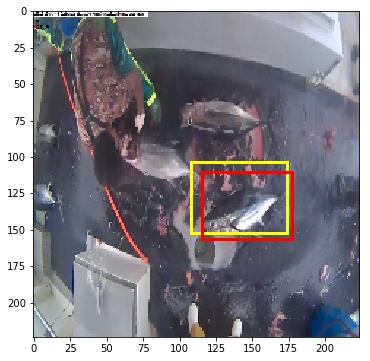

time: 174 ms


In [64]:
show_bb_pred(1)

In [65]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

224/400 [===============>..............] - ETA: 0s

[0.174540184289217,
 115.48540603637696,
 0.05905477224441711,
 0.82499999999999996,
 0.98999999999999999]

time: 114 ms


In [66]:
model.save_weights(path+'models/bn_anno.h5')

time: 78.4 ms


In [67]:
model.load_weights(path+'models/bn_anno.h5')

time: 27.4 ms


## Larger Sizes

In [68]:
#Now we will make the images bigger
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

Found 3617 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
time: 2min 25s


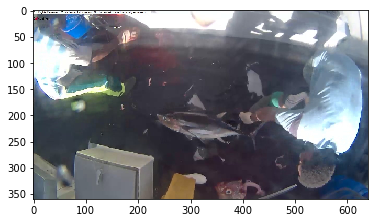

time: 167 ms


In [69]:
# shows image, plots training 1
plot(trn[1])

In [70]:
# Gets data for test
test = get_data(path+'test', (360,640))

Found 1000 images belonging to 1 classes.
time: 36.1 s


In [71]:
# Saves all of our results
save_array(path+'results/trn_640.dat', trn)
save_array(path+'results/val_640.dat', val)
save_array(path+'results/test_640.dat', test)

time: 8.45 s


In [72]:
# Loads them all again
trn = load_array(path+'results/trn_640.dat')
val = load_array(path+'results/val_640.dat')
test = load_array(path+'results/test_640.dat')

time: 16.6 s


Jeremy- We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the fully connected layers (since they don't make sense for non-default sizes). We will also remove the last max pooling layer, since we don't want to throw away information yet.

In [73]:
# make a model
vgg640 = Vgg16BN((360, 640)).model

time: 657 ms


In [74]:
# Provides a summary
vgg640.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 360, 640)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 362, 642)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 360, 640)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 362, 642)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [75]:
#removes the last layer
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

time: 31.4 ms


In [76]:
# Provides a summary #2
vgg640.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 360, 640)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 362, 642)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 360, 640)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 362, 642)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [77]:
# Runs the convolutional model
# Batch size 32 is too big
conv_val_feat = vgg640.predict(val, batch_size=16, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=16, verbose=1)

3617/3617 [==============================] - 279s   
time: 5min 15s


In [78]:
# Saves our array
save_array(path+'results/conv_val_640.dat', conv_val_feat)
save_array(path+'results/conv_trn_640.dat', conv_trn_feat)

time: 5.09 s


In [79]:
# runs the test
conv_test_feat = vgg640.predict(test, batch_size=16, verbose=1)

1000/1000 [==============================] - 77s    
time: 1min 17s


In [80]:
# saves test arrat
save_array(path+'results/conv_test_640.dat', conv_test_feat)

time: 1.26 s


In [81]:
# Loads everything
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')
conv_test_feat = load_array(path+'results/conv_test_640.dat')

time: 23.8 s


### Fully convolutional net (FCN)

In [82]:
# creates a convolutional net
conv_layers,_ = split_at(vgg640, Convolution2D)

time: 3.48 ms


In [83]:
# what is nf?
nf=128; p=0.0

time: 1.95 ms


In [84]:
# New set of layers with convultional nets
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(8,3,3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

time: 10 ms


In [85]:
lrg_model = Sequential(get_lrg_layers())

time: 68.6 ms


In [86]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_13 (BatchNorm (None, 512, 22, 40)   2048        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_13[0][0]      
____________________________________________________________________________________________________
batchnormalization_14 (BatchNorm (None, 128, 22, 40)   512         convolution2d_27[0][0]           
____________________________________________________________________________________________________
maxpooling2d_14 (MaxPooling2D)   (None, 128, 11, 20)   0           batchnormalization_14[0][0]      
___________________________________________________________________________________________

In [87]:
#sets up the large model
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

time: 8.94 ms


In [88]:
#fits teh large model
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3617 samples, validate on 400 samples
Epoch 1/2
3617/3617 [==============================] - 8s - loss: 0.6227 - acc: 0.8020 - val_loss: 2.3708 - val_acc: 0.3900
Epoch 2/2
3617/3617 [==============================] - 7s - loss: 0.1137 - acc: 0.9704 - val_loss: 0.7061 - val_acc: 0.7425


time: 24.5 s


In [89]:
# changes optimization
lrg_model.optimizer.lr=1e-5

time: 1.77 ms


In [90]:
# run it another time
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3617 samples, validate on 400 samples
Epoch 1/6
3617/3617 [==============================] - 7s - loss: 0.0384 - acc: 0.9903 - val_loss: 0.1453 - val_acc: 0.9725
Epoch 2/6
3617/3617 [==============================] - 7s - loss: 0.0180 - acc: 0.9950 - val_loss: 0.0856 - val_acc: 0.9825
Epoch 3/6
3617/3617 [==============================] - 7s - loss: 0.0051 - acc: 0.9989 - val_loss: 0.0655 - val_acc: 0.9850
Epoch 4/6
3617/3617 [==============================] - 7s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0680 - val_acc: 0.9850
Epoch 5/6
3617/3617 [==============================] - 7s - loss: 6.7187e-04 - acc: 1.0000 - val_loss: 0.0727 - val_acc: 0.9850
Epoch 6/6
3617/3617 [==============================] - 7s - loss: 4.8278e-04 - acc: 1.0000 - val_loss: 0.0708 - val_acc: 0.9850


time: 45 s


Jeremy: When I submitted the results of this model to Kaggle, I got the best single model results of any shown here (ranked 22nd on the leaderboard as at Dec-6-2016.)

In [91]:
# save the newer larger weights
lrg_model.save_weights(path+'models/lrg_nmp.h5')

time: 51 ms


In [92]:
# loads the larger weights
lrg_model.load_weights(path+'models/lrg_nmp.h5')

time: 12.8 ms


In [93]:
# what is evaluate?
lrg_model.evaluate(conv_val_feat, val_labels)

400/400 [==============================] - 0s     


[0.070828115644399073, 0.98499999999999999]

time: 537 ms


In [94]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-4].output)

time: 705 ms


In [95]:
# resizes
def get_cm(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

time: 2.93 ms


In [96]:
inp = np.expand_dims(conv_val_feat[0], 0)
np.round(lrg_model.predict(inp)[0],2)

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

time: 743 ms


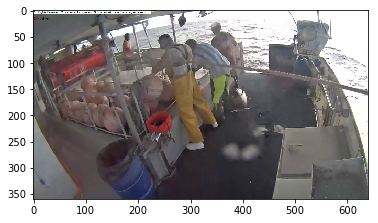

time: 205 ms


In [97]:
# Displays the photo
plt.imshow(to_plot(val[3]))

In [98]:
cm = get_cm(inp, 2)

time: 18.5 ms


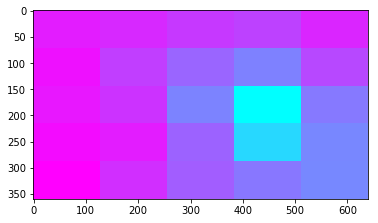

time: 119 ms


In [99]:
# Shows where fishy stuff is
plt.imshow(cm, cmap="cool")

### Only convolutional models

In [100]:
# Modelslrg_model.summary()
# no max pooling/ added another layer
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(8,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

time: 4.88 ms


In [101]:
lrg_model = Sequential(get_lrg_layers())

time: 38.4 ms


In [102]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_17 (BatchNorm (None, 512, 22, 40)   2048        batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
convolution2d_31 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_17[0][0]      
____________________________________________________________________________________________________
batchnormalization_18 (BatchNorm (None, 128, 22, 40)   512         convolution2d_31[0][0]           
____________________________________________________________________________________________________
convolution2d_32 (Convolution2D) (None, 128, 22, 40)   147584      batchnormalization_18[0][0]      
___________________________________________________________________________________________

In [103]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

time: 7.35 ms


In [104]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3617 samples, validate on 400 samples
Epoch 1/2
3617/3617 [==============================] - 9s - loss: 0.8945 - acc: 0.7374 - val_loss: 2.8017 - val_acc: 0.4475
Epoch 2/2
3617/3617 [==============================] - 9s - loss: 0.2679 - acc: 0.9245 - val_loss: 1.0743 - val_acc: 0.6950


time: 24.4 s


In [105]:
lrg_model.optimizer.lr=1e-5

time: 604 µs


In [106]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3617 samples, validate on 400 samples
Epoch 1/6
3617/3617 [==============================] - 9s - loss: 0.1322 - acc: 0.9618 - val_loss: 0.1993 - val_acc: 0.9350
Epoch 2/6
3617/3617 [==============================] - 9s - loss: 0.0711 - acc: 0.9804 - val_loss: 0.1429 - val_acc: 0.9600
Epoch 3/6
3617/3617 [==============================] - 9s - loss: 0.0356 - acc: 0.9898 - val_loss: 0.0916 - val_acc: 0.9800
Epoch 4/6
3617/3617 [==============================] - 9s - loss: 0.0223 - acc: 0.9936 - val_loss: 0.0874 - val_acc: 0.9800
Epoch 5/6
3617/3617 [==============================] - 9s - loss: 0.0152 - acc: 0.9961 - val_loss: 0.0956 - val_acc: 0.9825
Epoch 6/6
3617/3617 [==============================] - 9s - loss: 0.0148 - acc: 0.9959 - val_loss: 0.0854 - val_acc: 0.9850


time: 58 s


In [107]:
lrg_model.save_weights(path+'models/lrg_0mp.h5')

time: 13.1 ms


In [108]:
lrg_model.load_weights(path+'models/lrg_0mp.h5')

time: 8.92 ms


#### Create heatmap

In [109]:
# Make layers for new heatmap
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

time: 568 ms


In [110]:
# 
def get_cm2(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

time: 2.09 ms


In [111]:
inp = np.expand_dims(conv_val_feat[0], 0)

time: 2 ms


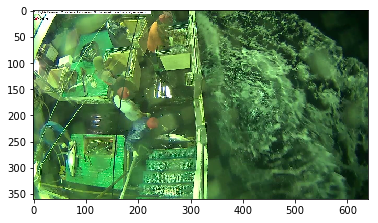

time: 177 ms


In [112]:
# Look at an image
plt.imshow(to_plot(val[2]))

In [113]:
cm = get_cm2(inp, 0)

time: 5 ms


In [114]:
cm = get_cm2(inp, 4)

time: 4.7 ms


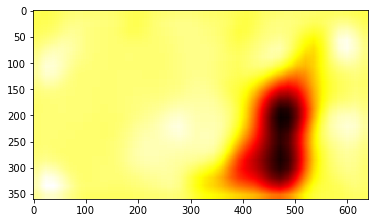

time: 127 ms


In [115]:
# SHows the plot
plt.imshow(cm, cmap="hot")

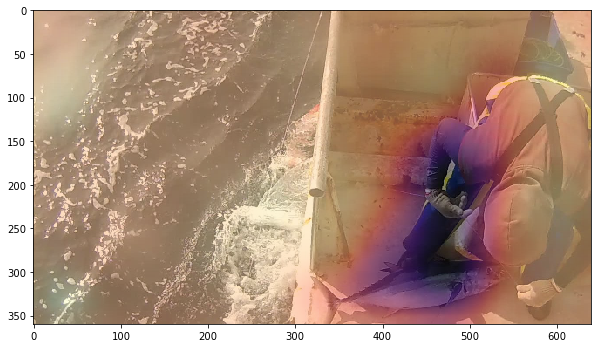

time: 365 ms


In [116]:
# puts one over another
plt.figure(figsize=(10,10))
plot(val[0])
plt.imshow(cm, cmap="magma", alpha=0.5)

### Inception mini-net

In [117]:
# How to use many small blocks
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1, 1)):
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample, activation='relu', border_mode='same')(x)
    return BatchNormalization(axis=1)(x)

time: 3.55 ms


In [118]:
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=1)

time: 17.7 ms


In [119]:
inp = Input(vgg640.layers[-1].output_shape[1:]) 
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Convolution2D(8,3,3, border_mode='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

time: 182 ms


In [120]:
lrg_model = Model([inp], outp)

time: 1.77 ms


In [121]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

time: 7.67 ms


In [122]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3617 samples, validate on 400 samples
Epoch 1/2
3617/3617 [==============================] - 8s - loss: 1.2227 - acc: 0.5886 - val_loss: 1.8809 - val_acc: 0.2275
Epoch 2/2
3617/3617 [==============================] - 8s - loss: 0.3893 - acc: 0.8900 - val_loss: 1.0172 - val_acc: 0.8125


time: 50.3 s


In [123]:
lrg_model.optimizer.lr=1e-5

time: 776 µs


In [124]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3617 samples, validate on 400 samples
Epoch 1/6
3617/3617 [==============================] - 8s - loss: 0.1328 - acc: 0.9668 - val_loss: 0.4328 - val_acc: 0.9125
Epoch 2/6
3617/3617 [==============================] - 8s - loss: 0.0548 - acc: 0.9892 - val_loss: 0.2035 - val_acc: 0.9550
Epoch 3/6
3617/3617 [==============================] - 8s - loss: 0.0345 - acc: 0.9920 - val_loss: 0.1307 - val_acc: 0.9675
Epoch 4/6
3617/3617 [==============================] - 8s - loss: 0.0168 - acc: 0.9981 - val_loss: 0.1024 - val_acc: 0.9775
Epoch 5/6
3617/3617 [==============================] - 8s - loss: 0.0087 - acc: 0.9997 - val_loss: 0.1060 - val_acc: 0.9750
Epoch 6/6
3617/3617 [==============================] - 8s - loss: 0.0082 - acc: 0.9986 - val_loss: 0.0970 - val_acc: 0.9700


time: 49.9 s


In [125]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, val_labels))

Train on 3617 samples, validate on 400 samples
Epoch 1/10
3617/3617 [==============================] - 8s - loss: 0.0084 - acc: 0.9983 - val_loss: 0.0846 - val_acc: 0.9800
Epoch 2/10
3617/3617 [==============================] - 8s - loss: 0.0053 - acc: 0.9994 - val_loss: 0.0842 - val_acc: 0.9825
Epoch 3/10
3617/3617 [==============================] - 8s - loss: 0.0044 - acc: 0.9994 - val_loss: 0.1091 - val_acc: 0.9800
Epoch 4/10
3617/3617 [==============================] - 8s - loss: 0.0027 - acc: 0.9997 - val_loss: 0.0711 - val_acc: 0.9825
Epoch 5/10
3617/3617 [==============================] - 8s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0637 - val_acc: 0.9875
Epoch 6/10
3617/3617 [==============================] - 8s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0707 - val_acc: 0.9825
Epoch 7/10
3617/3617 [==============================] - 8s - loss: 0.0013 - acc: 0.9997 - val_loss: 0.0726 - val_acc: 0.9800
Epoch 8/10
3617/3617 [==============================] - 8s - loss: 0.0060 - ac

time: 1min 23s


In [126]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

time: 45.1 ms


In [127]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

time: 34 ms


## Pseudo-labeling

In [128]:
conv_test_feat

array([[[[  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
         [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
         [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
         ..., 
         [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
         [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
         [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ]],

        [[  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
         [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
         [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
         ..., 
         [ 14.468 ,  26.4199,   7.7957, ...,   0.    ,   0.    ,   0.    ],
         [ 17.8225,  32.9999,   9.3635, ...,   0.    ,   0.    ,   0.    ],
         [ 23.9651,  30.1254,   8.8786, ...,   0.    ,   0.    ,   0.    ]],

        [[  0.    ,   0.    ,   0.    , ...,   0.    ,

time: 18.1 ms


In [129]:
#preds = model.predict([conv_test_feat, test_sizes], batch_size=batch_size*2)
preds = model.predict(conv_test_feat, batch_size=batch_size*2)
#preds = model.predict(conv_test_feat, batch_size=batch_size)

ValueError: Error when checking : expected input_3 to have shape (None, 512, 14, 14) but got array with shape (1000, 512, 22, 40)

time: 205 ms


In [ ]:
gen = image.ImageDataGenerator()

In [ ]:
test_batches = gen.flow(conv_test_feat, preds, batch_size=16)

In [ ]:
val_batches = gen.flow(conv_val_feat, val_labels, batch_size=4)

In [ ]:
batches = gen.flow(conv_feat, trn_labels, batch_size=44)

In [ ]:
mi = MixIterator([batches, test_batches, val_batches)

In [ ]:
bn_model.fit_generator(mi, mi.N, nb_epoch=8, validation_data=(conv_val_feat, val_labels))

## Submit

In [ ]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)

In [ ]:
lrg_model.evaluate(conv_val_feat, val_labels, batch_size*2)

In [ ]:
preds = model.predict(conv_test_feat, batch_size=batch_size)

In [ ]:
preds = preds[1]

In [ ]:
test = load_array(path+'results/test_640.dat')

In [ ]:
test = load_array(path+'results/test.dat')

In [ ]:
preds = conv_model.predict(test, batch_size=32)

In [ ]:
subm = do_clip(preds,0.82)

In [ ]:
subm_name = path+'results/subm_bb.gz'

In [ ]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [ ]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

In [ ]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [ ]:
FileLink(subm_name)